## Imports

In [1]:
from tabula import read_pdf
from bs4 import BeautifulSoup
import urllib
from urllib.request import urlretrieve
import pandas as pd
import numpy as np 
from datetime import date, timedelta, datetime
import requests
import shutil
import os.path

import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
plt.style.use('seaborn-deep')

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")


## Downloading the last data

* Download the last file from the web page official web page of the [Spanish Minitry of Health](https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/situacionActual.htm)

In [2]:
def download_file(url,text):
    # we read the content of the page
    response = requests.get(url,verify=False)
    
    # open the response with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    search_string = 'Actualiza'

    # search for the link with the searching string
    for link in soup.find_all('a'):
        if link.text.find(search_string) != -1:
            href = link['href']
            break
            
    # get the url of the file
    if href.find('../') != -1:
        url_parts = url.split('/')
        href = href.replace('../', '')
        href = url_parts[0] + '//' + url_parts[2] +  '//' + href
        
    file_downloaded = False
    # download the file
    if os.path.isfile(href.split('/')[-1]):
        # if the file alreade exists we don't download it
        file_downloaded = False
    else:
        # we download the file if it doesn't exist in the directory
        response = urllib.request.urlopen(href)
        urlretrieve(href, href.split('/')[-1])
        file_downloaded = True
    return file_downloaded, href.split('/')[-1]


In [3]:
url = 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/situacionActual.htm'
text = 'Actualiza'

# download the pdf file from the web page
file_downloaded, file = download_file(url,text)
print(file_downloaded)

False


* Extract the table from the pdf file into a dataframe

In [4]:
if file_downloaded == True:
    # get the tables inside the file
    df_current = read_pdf(file, multiple_tables=True)[0]
    
    # get old cases
    df_old_cases = pd.read_csv('data/ccaa_covid19_casos_long.csv') 

    # get old deads
    df_old_deaths = pd.read_csv('data/ccaa_covid19_fallecidos_long.csv') 

    # get old ucis
    df_old_uci = pd.read_csv('data/ccaa_covid19_uci_long.csv')
    
    # get old cases
    df_old_hospital = pd.read_csv('data/ccaa_covid19_hospitalizados_long.csv') 

    # get old deads
    df_old_healed = pd.read_csv('data/ccaa_covid19_altas_long.csv') 
    

## Wrangling the data

In [5]:
import re
def extract_number(cell):
   # cell = cell.str.replace('.', '')
    m = re.match(r"^-?[0-9][0-9,]+$", cell)
    if m:
        if ',' in m.group():
            return float(m.group().replace(',', '.'))
        else:
            return int(m.group())
    else:
        return 0

In [6]:
if file_downloaded == True:
    regions = ['Andalucía', 'Aragón', 'Asturias', 'Baleares', 'Canarias', 
               'Cantabria', 'Castilla La Mancha', 'Castilla y León', 
               'Cataluña', 'Ceuta', 'C. Valenciana', 
               'Extremadura', 'Galicia', 'Madrid', 'Melilla', 'Murcia', 
               'Navarra', 'País Vasco', 'La Rioja', 'ESPAÑA']
    
    df_current.columns = ['CCAA', 'TOTAL conf.', 'IA (14 d.)', 'Hospitalizados', 'UCI', 'Fallecidos', 'Curados', 'Nuevos']
    df_current = df_current[df_current.CCAA.isin(regions) == True]

    
    
    df_current = df_current.set_index('CCAA').applymap(extract_number).reset_index()
    
    # add a column witn the today date
    df_current['date'] = date.today()

    # adapt names of regions and total
    df_current = df_current.replace('ESPAÑA', 'Total')
    df_current = df_current.replace('Castilla La Mancha', 'Castilla-La Mancha')

    # adapt names of regions and total
    df_current = df_current.replace('ESPAÑA', 'Total')
    df_current = df_current.replace('Castilla La Mancha', 'Castilla-La Mancha')

    # corrections in the type of dates
    df_old_cases.date = df_old_cases.date.apply(lambda x :  pd.to_datetime(x, format='%Y/%m/%d').date())
    df_old_deaths.date = df_old_deaths.date.apply(lambda x :  pd.to_datetime(x, format='%Y/%m/%d').date())
    df_old_uci.date = df_old_uci.date.apply(lambda x :  pd.to_datetime(x, format='%Y/%m/%d').date())
    df_old_hospital.date = df_old_hospital.date.apply(lambda x :  pd.to_datetime(x, format='%Y/%m/%d').date())
    df_old_healed.date = df_old_healed.date.apply(lambda x :  pd.to_datetime(x, format='%Y/%m/%d').date())

## Update files with new data

In [7]:
# get the codes of the regions
if file_downloaded == True:
    df_codes = df_old_cases[['cod_ine', 'CCAA']].drop_duplicates()
    # Update Total Cases
    # get the total information from the current data
    df_aux = df_current[['CCAA', 'TOTAL conf.', 'date']]
    # adapt the columns
    df_aux.columns = ['CCAA', 'total', 'date']
    # add the region codes
    df_aux = df_aux.merge(df_codes, on='CCAA', how='left')
    # merge with old data
    df_new_cases = df_old_cases.append(df_aux)

    # Update Number of Deaths
    # get the dead cases information from the current data
    df_aux = df_current[['CCAA', 'Fallecidos', 'date']]
    # adapt the columns
    df_aux.columns = ['CCAA', 'total', 'date']
    # add the region codes
    df_aux = df_aux.merge(df_codes, on='CCAA', how='left')
    # merge with old data
    df_new_deaths = df_old_deaths.append(df_aux)

    #Update Number of ICUs
    # get the UCI cases information from the current data
    df_aux = df_current[['CCAA', 'UCI', 'date']]
    # adapt the columns
    df_aux.columns = ['CCAA', 'total', 'date']
    # add the region codes
    df_aux = df_aux.merge(df_codes, on='CCAA', how='left')
    # merge with old data
    df_new_uci = df_old_uci.append(df_aux)
    
    #Update Number of hospitalized cases
    # get the hopitalized cases information from the current data
    df_aux = df_current[['CCAA', 'Hospitalizados', 'date']]
    # adapt the columns
    df_aux.columns = ['CCAA', 'total', 'date']
    # add the region codes
    df_aux = df_aux.merge(df_codes, on='CCAA', how='left')
    # merge with old data
    df_new_hospital = df_old_hospital.append(df_aux)
    
    #Update Number of healed cases
    # get the healed cases information from the current data
    df_aux = df_current[['CCAA', 'Curados', 'date']]
    # adapt the columns
    df_aux.columns = ['CCAA', 'total', 'date']
    # add the region codes
    df_aux = df_aux.merge(df_codes, on='CCAA', how='left')
    # merge with old data
    df_new_healed = df_old_healed.append(df_aux)
    
    # save current new files to old directory
    shutil.copy2('data/ccaa_covid19_casos_long.csv', 'old/ccaa_covid19_casos_long.csv') 
    shutil.copy2('data/ccaa_covid19_fallecidos_long.csv', 'old/ccaa_covid19_fallecidos_long.csv') 
    shutil.copy2('data/ccaa_covid19_uci_long.csv', 'old/ccaa_covid19_uci_long.csv')
    shutil.copy2('data/ccaa_covid19_hospitalizados_long.csv', 'old/ccaa_covid19_hospitalizados_long.csv')
    shutil.copy2('data/ccaa_covid19_altas_long.csv', 'old/ccaa_covid19_altas_long.csv')
    
    # update files in new directory
    df_new_cases.sort_values(by = ['cod_ine', 'date']).to_csv (r'data/ccaa_covid19_casos_long.csv', index = False, header=True, encoding = 'UTF-8')
    df_new_deaths.sort_values(by = ['cod_ine', 'date']).to_csv (r'data/ccaa_covid19_fallecidos_long.csv', index = False, header=True, encoding = 'UTF-8')
    df_new_uci.sort_values(by = ['cod_ine', 'date']).to_csv (r'data/ccaa_covid19_uci_long.csv', index = False, header=True, encoding = 'UTF-8')
    df_new_hospital.sort_values(by = ['cod_ine', 'date']).to_csv (r'data/ccaa_covid19_hospitalizados_long.csv', index = False, header=True, encoding = 'UTF-8')
    df_new_healed.sort_values(by = ['cod_ine', 'date']).to_csv (r'data/ccaa_covid19_altas_long.csv', index = False, header=True, encoding = 'UTF-8')

## Visualizations

We read the last updated files:

In [8]:
# get new cases
df_new_cases = pd.read_csv('data/ccaa_covid19_casos_long.csv') 

# get new deaths data
df_new_deaths = pd.read_csv('data/ccaa_covid19_fallecidos_long.csv') 

# get new ucis data
df_new_uci = pd.read_csv('data/ccaa_covid19_uci_long.csv')

# get new hospital data
df_new_hospital = pd.read_csv('data/ccaa_covid19_hospitalizados_long.csv')

# get new healed data
df_new_healed = pd.read_csv('data/ccaa_covid19_altas_long.csv')

# get icu in 2017 data
df_new_icu_beds_2017 = pd.read_csv('data/ccaa_camas_uci_2017.csv')


# corrections in the type of dates
df_new_cases.date = df_new_cases.date.apply(lambda x :  pd.to_datetime(x, format='%Y/%m/%d').date())
df_new_deaths.date = df_new_deaths.date.apply(lambda x :  pd.to_datetime(x, format='%Y/%m/%d').date())
df_new_uci.date = df_new_uci.date.apply(lambda x :  pd.to_datetime(x, format='%Y/%m/%d').date())
df_new_hospital.date = df_new_hospital.date.apply(lambda x :  pd.to_datetime(x, format='%Y/%m/%d').date())
df_new_healed.date = df_new_healed.date.apply(lambda x :  pd.to_datetime(x, format='%Y/%m/%d').date())

# rename the column total to make a merge
df_new_cases = df_new_cases.rename(columns={'total':'total_cases'})
df_new_deaths = df_new_deaths.rename(columns={'total':'total_deaths'})
df_new_uci = df_new_uci.rename(columns={'total':'total_ucis'})
df_new_hospital = df_new_hospital.rename(columns={'total':'total_hospital'})
df_new_healed = df_new_healed.rename(columns={'total':'total_healed'})
df_new_icu_beds_2017 = df_new_icu_beds_2017.rename(columns={'Total':'total_icu_beds'})

# add a row with the total icu beds in df_new_icu_beds_2017 for all the regions
#df_new_icu_beds_2017 = df_new_icu_beds_2017.drop(columns= 'CCAA')
#aux = df_new_icu_beds_2017.sum(axis=0)
#aux.cod_ine = 0
#df_new_icu_beds_2017 = df_new_icu_beds_2017.append(aux, ignore_index=True)

# merge all the datasets
dataset = pd.merge(df_new_cases, df_new_deaths, how='left', on=['CCAA', 'cod_ine','date'])
dataset = pd.merge(dataset, df_new_uci, how='left', on=['CCAA', 'cod_ine','date'])
dataset = pd.merge(dataset, df_new_hospital, how='left', on=['CCAA', 'cod_ine','date'])
dataset = pd.merge(dataset, df_new_healed, how='left', on=['CCAA', 'cod_ine','date'])
dataset = pd.merge(dataset, df_new_icu_beds_2017, how='left', on=['CCAA', 'cod_ine'])
dataset = dataset.sort_values(by=['cod_ine', 'date'])


We draw two coloumns of plosts. The first columns shows the total number of cases detected in each region in logarithmic scale. The second columns draw the number of deaths per region.

The first row of graphs depicts the total numbers in Spain.

The blue line shows an increment of a 100% each 2 days, 3 days and 4 days. To calculate the slope we have used as reference the day in which the number of cases was 10 or more. If the region hasn't have 10 cases we use the number of cases in March 8th of 2020.

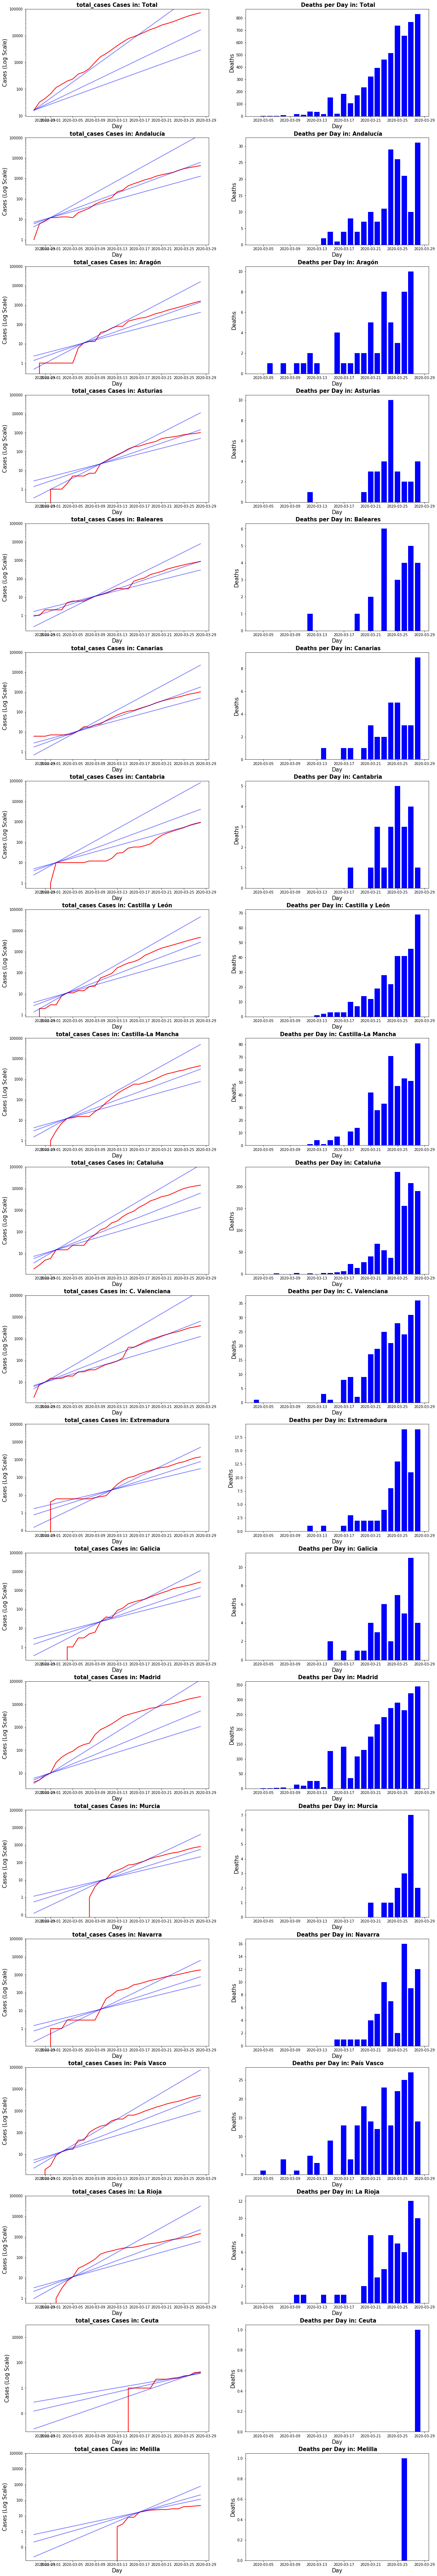

In [9]:
# we draw two coloumns of 20 plots.
fig, ax = plt.subplots(ncols = 2, nrows = len(dataset.CCAA.unique()) , figsize = [20,130])

# in the first column we draw the total_cases number of cases per region
for num, region in enumerate(dataset.CCAA.unique()):
    # read the data of cases for each region
    df_region = dataset[df_new_cases.CCAA == region]
    # day of reference to draw the blue line (increment of a 100% each 3 days)
    
    
    if df_region.total_cases.max() >= 10:
        date_reference = df_region[df_region.total_cases >= 10].head(1).date.values[0]
    else:
        date_reference_str = '2020-03-08'
        date_reference = datetime.strptime(date_reference_str, '%Y-%m-%d').date()
    
    # the number of cases the day of reference
    value_reference = df_region[df_region.date == date_reference].total_cases.values[0]
    
    # last day of the graph and number of days since the day of reference
    date_line_2 = df_region.date.max()
    max_limit = date_line_2 - date_reference
    
    # first day of the graph and number of days to the day of reference
    date_line_1 = df_region.date.min()
    min_limit = date_reference - date_line_1
    
    # extrapolation of the number of cases for the blue line
    value_line_3_1 = value_reference / (2 ** (min_limit.days/3))
    value_line_3_2 = value_reference * (2 ** (max_limit.days/3))
    
    # extrapolation of the number of cases for the blue line
    value_line_4_1 = value_reference / (2 ** (min_limit.days/4))
    value_line_4_2 = value_reference * (2 ** (max_limit.days/4))
    
    # extrapolation of the number of cases for the blue line
    value_line_2_1 = value_reference / (2 ** (min_limit.days/2))
    value_line_2_2 = value_reference * (2 ** (max_limit.days/2))
    
    # draw the data in red
    ax[num, 0].plot(df_region.date,
             df_region.total_cases, 
             color='red',  
             linewidth = 2)
    
    # draw a blue line with the reference
    ax[num, 0].plot([date_line_1, date_line_2],
             [value_line_3_1, value_line_3_2],
             color='blue',  
             linewidth = 2,
             alpha = 0.5)
    
    # draw a blue line with the reference
    ax[num, 0].plot([date_line_1, date_line_2],
             [value_line_4_1, value_line_4_2],
             color='blue',  
             linewidth = 2,
             alpha = 0.5)
    
    # draw a blue line with the reference
    ax[num, 0].plot([date_line_1, date_line_2],
             [value_line_2_1, value_line_2_2],
             color='blue',  
             linewidth = 2,
             alpha = 0.5)
    
    # we select a logarithmic scale in the y-axis
    ax[num, 0].set_yscale('log')
    ax[num, 0].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    # adjust the visualization of the graph
    ax[num, 0].set_ylim([0, 100000])
    ax[num, 0].set_xlabel('Day', fontsize=15)
    ax[num, 0].set_title('total_cases Cases in: ' + region, fontdict = {'fontsize': 15, 'fontweight': 'bold'})
    ax[num, 0].set_ylabel('Cases (Log Scale)', fontsize=15)
    #ax[num, 0].tick_params(axis='both', which='major', labelsize=13);

    
    # in the second column we draw the number of deaths per region    
    # add a column with the increment per day
    df_region['increment'] = df_region.total_deaths.diff(periods=1)
    
    # it draws a bar plot with the increment of deaths per day
    ax[num, 1].bar(df_region.date,
             df_region.increment, 
             color='blue')
    
    # adjust the visualization of the graph
    ax[num, 1].set_xlabel('Day', fontsize=15)
    ax[num, 1].set_title(' Deaths per Day in: ' + region, fontdict = {'fontsize': 15, 'fontweight': 'bold'})
    ax[num, 1].set_ylabel('Deaths', fontsize=15)


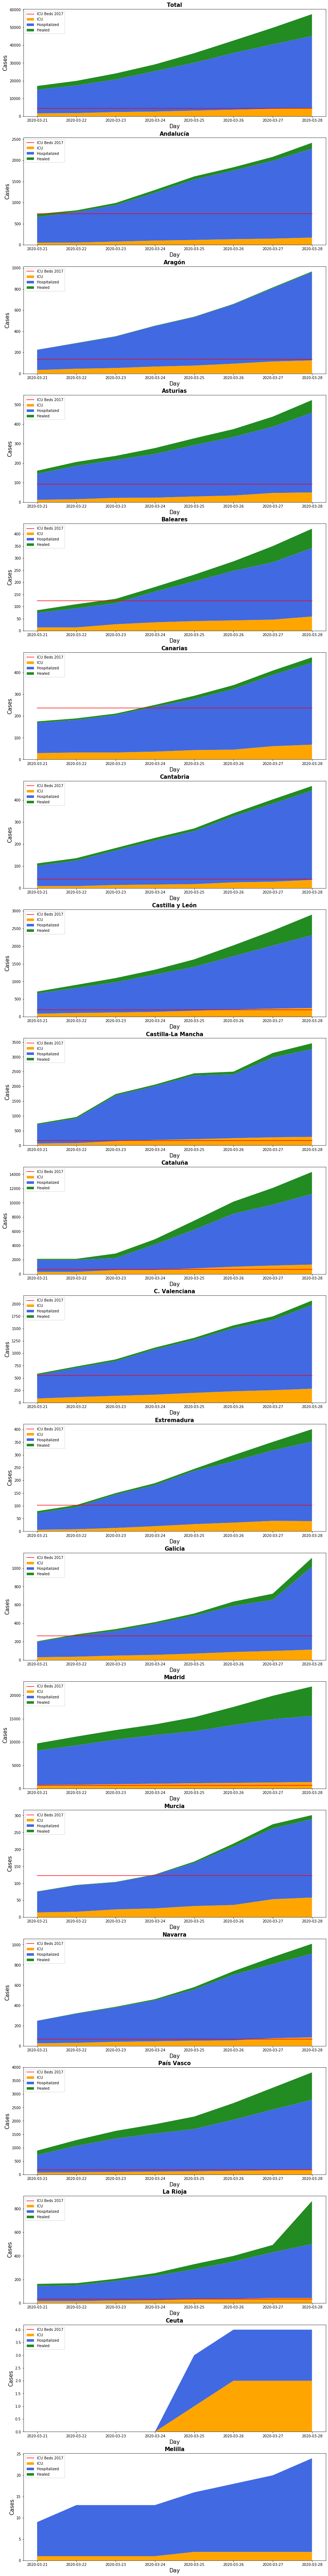

In [10]:
# we draw two coloumns of 20 plots.
fig, ax = plt.subplots(ncols = 1, nrows = len(dataset.CCAA.unique()) , figsize = [15,130])

# in the first column we draw the total_cases number of cases per region
for num, region in enumerate(dataset.CCAA.unique()):
    # read the data of cases for each region
    df_region = dataset[df_new_cases.CCAA == region]
    df_region = df_region[df_region.date >= datetime.strptime('2020-03-21', '%Y-%m-%d').date()]

    
    # draw the data in a stack plot
    ax[num].stackplot(df_region.date, df_region.total_ucis, df_region.total_hospital, df_region.total_healed,
             labels =[ 'ICU', 'Hospitalized', 'Healed'],
             colors = ['orange', 'royalblue', 'forestgreen'])
    ax[num].plot(df_region.date, df_region.total_icu_beds, color='red',label ='ICU Beds 2017')

    # adjust the visualization of the graph
    ax[num].set_xlabel('Day', fontsize=15)
    ax[num].set_title(region, fontdict = {'fontsize': 15, 'fontweight': 'bold'})
    ax[num].set_ylabel('Cases', fontsize=15)
    ax[num].legend(loc='upper left')


    